In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs_revised.preprocessing import *
from custom_classes_defs_revised.unet1 import *

# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *


RND_STATE = 247
BATCH_SIZE = 256
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-02 15:43:31.697163: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 15:43:32.269153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 15:43:32.269410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 15:43:32.353751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 15:43:32.531037: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    # strategy = tf.distribute.MirroredStrategy()
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Sun Jun  2 15:43:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   36C    P0              35W / 250W |   1637MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
seis_path = '../data_thebe/seismic/'
label_path = '../data_thebe/fault/'

thebe_data = Thebe(seis_path,label_path)

train_dataset = thebe_data.data_generator(sub_group='train',batch_size = BATCH_SIZE, cache=NUM_GPU)
val_dataset = thebe_data.data_generator(sub_group='val',batch_size= BATCH_SIZE, cache= NUM_GPU)
x_test, y_test = thebe_data.data_generator(sub_group='test',as_numpy=True, cache=NUM_GPU)

print("Train Dataset:", train_dataset)

print("Size of training data: {}".format(thebe_data.train_size))
print("Size of validation data: {}".format(thebe_data.validation_size))
print("Size of test data: {}".format(thebe_data.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


2024-06-02 15:44:27.104201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None))>
Size of training data: 181029
Size of validation data: 64317
Size of test data: 66077
...elapsed time: ___ 0.90 minutes___


2024-06-02 15:45:10.377217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


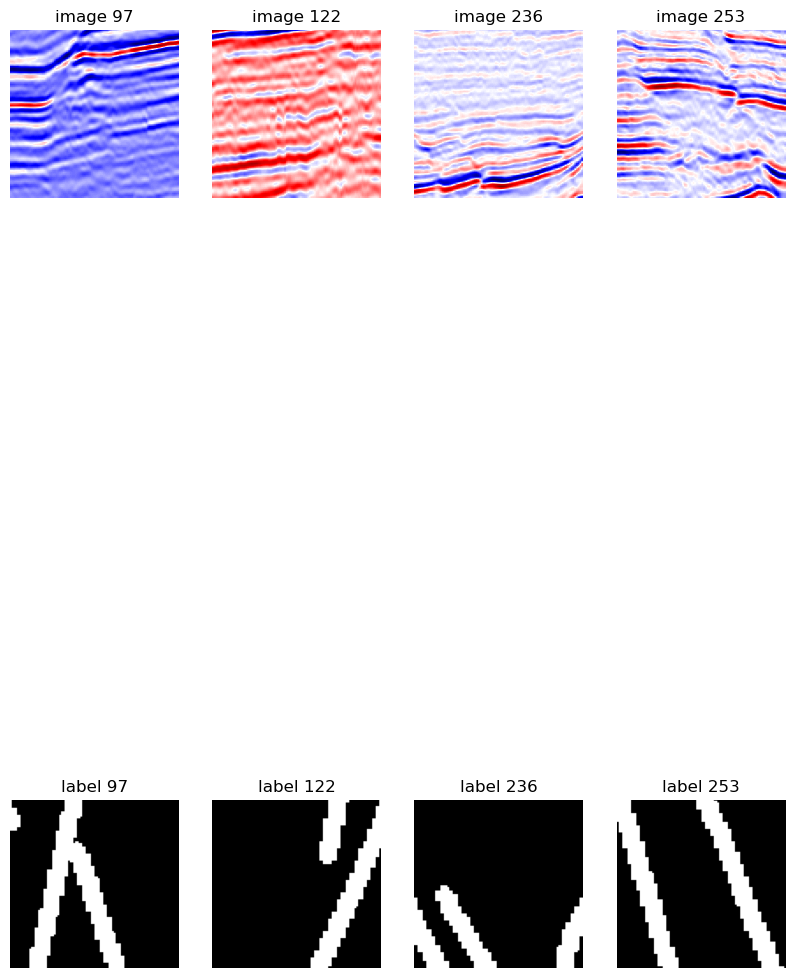

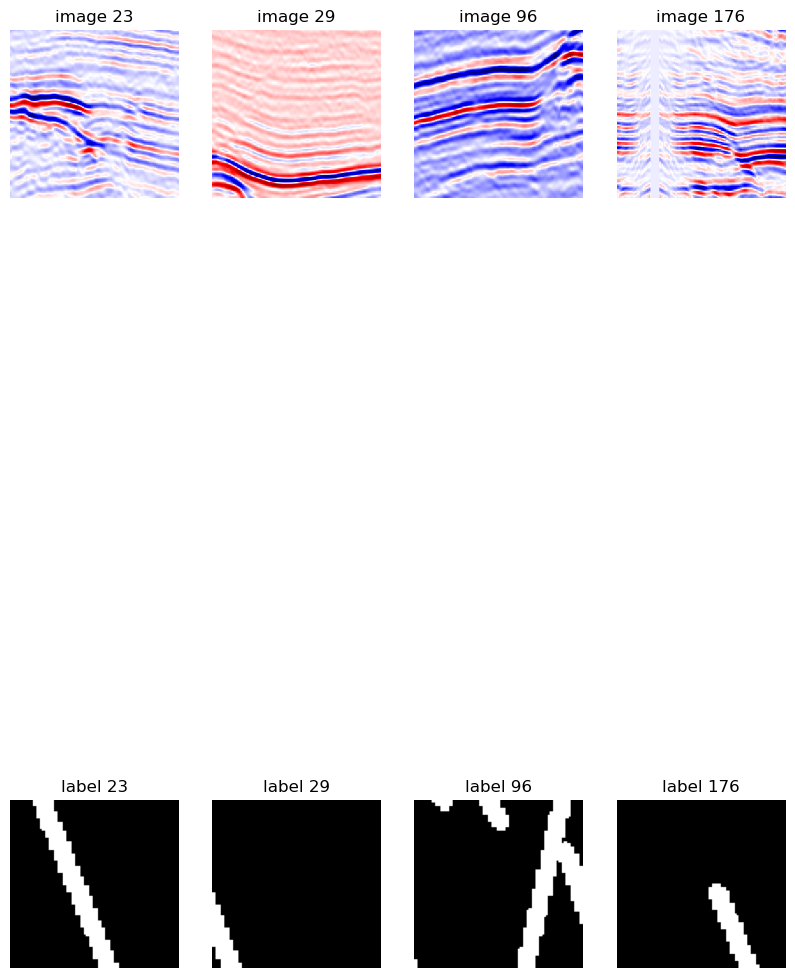

In [7]:
if INTERACTIVE_SESSION:
    X, y = next(train_dataset.as_numpy_iterator())
    # X, y = next(val_dataset.as_numpy_iterator())
    thebe_data.display_sample_images(X, y, num_images=4)
    thebe_data.display_sample_images(X, y, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/new/unet1',
    img_shape=thebe_data.img_size,
    target_size=thebe_data.img_size,
    threshold=thebe_data.threshold,
    pos_label=thebe_data.pos_label,
    train_size=thebe_data.train_size,
    test_size=thebe_data.test_size,
    new_training_session=False,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=thebe_data.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=100, 
    lr_monitor='val_loss',
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=thebe_data.pos_label, threshold=thebe_data.threshold)
conf.set(
    'compile', metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
           save_path: ./Thebe/new/unet1
             scaling: 1
         target_size: (96, 96)
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 256
                       shuffle

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    # strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        conf = model_config(
            epochs=100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            scaling=1,
            save_path='./Thebe/new/unet1',
            img_shape=thebe_data.img_size,
            target_size=thebe_data.img_size,
            threshold=thebe_data.threshold,
            pos_label=thebe_data.pos_label,
            train_size=thebe_data.train_size,
            test_size=thebe_data.test_size,
            new_training_session=False,
            multiple_gpu_device=(NUM_GPU>1),
            validation_size=thebe_data.validation_size
        )

        callbacks = conf.callbacks(
            chkpt_monitor='val_f1_score', 
            es_monitor='val_loss',
            es_patience=100, 
            lr_monitor='val_loss',
        )

        conf.set( validation_data=val_dataset,  callbacks=callbacks )
        m1 = f1_score(positive_label=thebe_data.pos_label, threshold=thebe_data.threshold)
        conf.set(
            'compile',
            metrics= ['accuracy', m1]
        )

        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        #m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    #m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 1,952,417
Total trainable wieghts: 1,949,601
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/new/unet0
             scaling: 1
         target_size: (96, 96)
           test_size: 224122
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
               

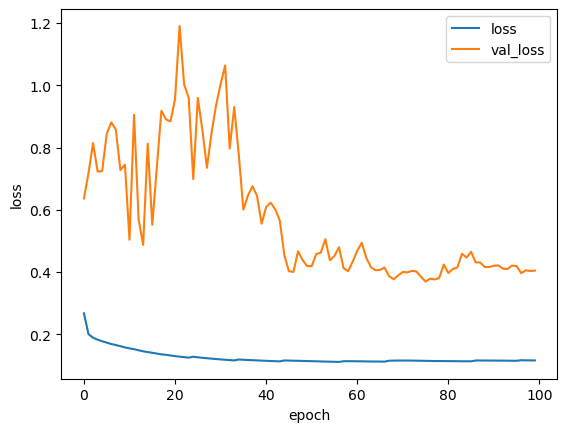

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)


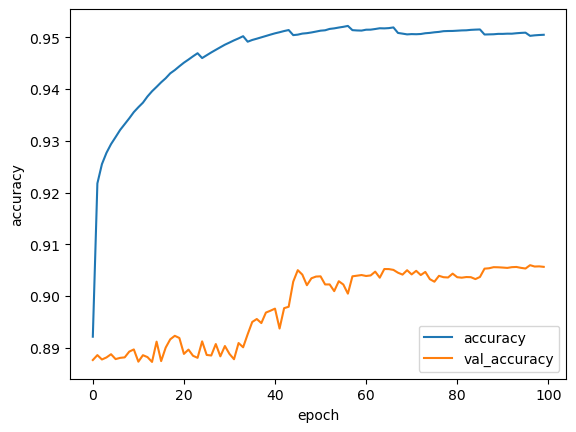

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

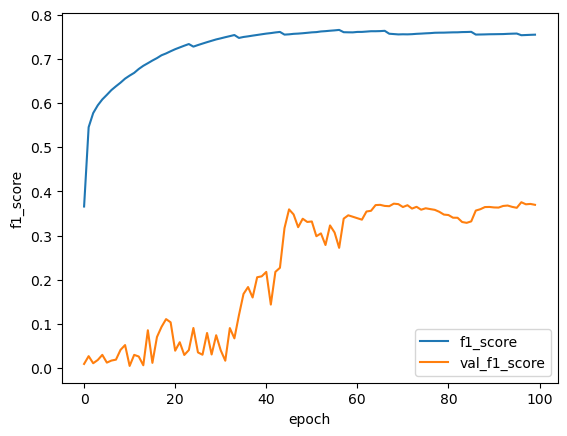

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

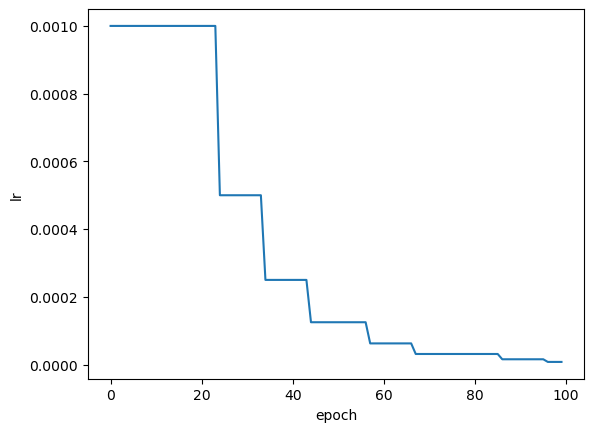

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
y_pred = model.predict(x_test)




	Evaluate unet model
-------------------------------------------------------


2024-06-02 15:45:45.005314: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


   1/2065 [..............................] - ETA: 2:42:38

   8/2065 [..............................] - ETA: 14s    

  17/2065 [..............................] - ETA: 13s

  26/2065 [..............................] - ETA: 12s

  35/2065 [..............................] - ETA: 12s

  44/2065 [..............................] - ETA: 12s

  53/2065 [..............................] - ETA: 12s

  62/2065 [..............................] - ETA: 12s

  71/2065 [>.............................] - ETA: 11s

  80/2065 [>.............................] - ETA: 11s

  89/2065 [>.............................] - ETA: 11s

  98/2065 [>.............................] - ETA: 11s

 107/2065 [>.............................] - ETA: 11s

 116/2065 [>.............................] - ETA: 11s

 125/2065 [>.............................] - ETA: 11s

 134/2065 [>.............................] - ETA: 11s

 143/2065 [=>............................] - ETA: 11s

 152/2065 [=>............................] - ETA: 11s

 161/2065 [=>............................] - ETA: 11s

 170/2065 [=>............................] - ETA: 11s

 179/2065 [=>............................] - ETA: 11s

 188/2065 [=>............................] - ETA: 10s

 197/2065 [=>............................] - ETA: 10s

 206/2065 [=>............................] - ETA: 10s

 215/2065 [==>...........................] - ETA: 10s

 224/2065 [==>...........................] - ETA: 10s

 233/2065 [==>...........................] - ETA: 10s

 242/2065 [==>...........................] - ETA: 10s

 251/2065 [==>...........................] - ETA: 10s

 260/2065 [==>...........................] - ETA: 10s

 269/2065 [==>...........................] - ETA: 10s

 278/2065 [===>..........................] - ETA: 10s

 287/2065 [===>..........................] - ETA: 10s

 296/2065 [===>..........................] - ETA: 10s

 305/2065 [===>..........................] - ETA: 10s

 314/2065 [===>..........................] - ETA: 10s

 323/2065 [===>..........................] - ETA: 10s

 332/2065 [===>..........................] - ETA: 10s

 341/2065 [===>..........................] - ETA: 10s

 350/2065 [====>.........................] - ETA: 9s 

 359/2065 [====>.........................] - ETA: 9s

 368/2065 [====>.........................] - ETA: 9s

 377/2065 [====>.........................] - ETA: 9s

 386/2065 [====>.........................] - ETA: 9s

 395/2065 [====>.........................] - ETA: 9s

 404/2065 [====>.........................] - ETA: 9s

 413/2065 [=====>........................] - ETA: 9s

 422/2065 [=====>........................] - ETA: 9s

 431/2065 [=====>........................] - ETA: 9s

 440/2065 [=====>........................] - ETA: 9s

 449/2065 [=====>........................] - ETA: 9s

 458/2065 [=====>........................] - ETA: 9s

 467/2065 [=====>........................] - ETA: 9s

 476/2065 [=====>........................] - ETA: 9s

 485/2065 [======>.......................] - ETA: 9s

 494/2065 [======>.......................] - ETA: 9s

 503/2065 [======>.......................] - ETA: 9s

 512/2065 [======>.......................] - ETA: 9s

 521/2065 [======>.......................] - ETA: 8s

 530/2065 [======>.......................] - ETA: 8s

 539/2065 [======>.......................] - ETA: 8s

 548/2065 [======>.......................] - ETA: 8s

 557/2065 [=======>......................] - ETA: 8s

 566/2065 [=======>......................] - ETA: 8s

 575/2065 [=======>......................] - ETA: 8s

 584/2065 [=======>......................] - ETA: 8s

 593/2065 [=======>......................] - ETA: 8s

 602/2065 [=======>......................] - ETA: 8s

 611/2065 [=======>......................] - ETA: 8s

 620/2065 [========>.....................] - ETA: 8s

 629/2065 [========>.....................] - ETA: 8s

 638/2065 [========>.....................] - ETA: 8s

 647/2065 [========>.....................] - ETA: 8s

 656/2065 [========>.....................] - ETA: 8s

 665/2065 [========>.....................] - ETA: 8s

 674/2065 [========>.....................] - ETA: 8s

 684/2065 [========>.....................] - ETA: 8s

 693/2065 [=========>....................] - ETA: 7s

 702/2065 [=========>....................] - ETA: 7s

 711/2065 [=========>....................] - ETA: 7s

 720/2065 [=========>....................] - ETA: 7s

 729/2065 [=========>....................] - ETA: 7s

 738/2065 [=========>....................] - ETA: 7s

 747/2065 [=========>....................] - ETA: 7s

 756/2065 [=========>....................] - ETA: 7s

 765/2065 [==========>...................] - ETA: 7s

 774/2065 [==========>...................] - ETA: 7s

 783/2065 [==========>...................] - ETA: 7s

 792/2065 [==========>...................] - ETA: 7s

 801/2065 [==========>...................] - ETA: 7s

 810/2065 [==========>...................] - ETA: 7s

 819/2065 [==========>...................] - ETA: 7s

 828/2065 [===========>..................] - ETA: 7s

 837/2065 [===========>..................] - ETA: 7s

 846/2065 [===========>..................] - ETA: 7s

 855/2065 [===========>..................] - ETA: 7s

 864/2065 [===========>..................] - ETA: 6s

 873/2065 [===========>..................] - ETA: 6s

 882/2065 [===========>..................] - ETA: 6s

 891/2065 [===========>..................] - ETA: 6s

 900/2065 [============>.................] - ETA: 6s

 909/2065 [============>.................] - ETA: 6s

 918/2065 [============>.................] - ETA: 6s

 927/2065 [============>.................] - ETA: 6s

 936/2065 [============>.................] - ETA: 6s

 945/2065 [============>.................] - ETA: 6s

 953/2065 [============>.................] - ETA: 6s

 962/2065 [============>.................] - ETA: 6s

 971/2065 [=============>................] - ETA: 6s

 980/2065 [=============>................] - ETA: 6s

 989/2065 [=============>................] - ETA: 6s

 998/2065 [=============>................] - ETA: 6s

1007/2065 [=============>................] - ETA: 6s

1016/2065 [=============>................] - ETA: 6s

1025/2065 [=============>................] - ETA: 6s

1034/2065 [==============>...............] - ETA: 5s

1043/2065 [==============>...............] - ETA: 5s

1052/2065 [==============>...............] - ETA: 5s

1061/2065 [==============>...............] - ETA: 5s

1070/2065 [==============>...............] - ETA: 5s

1079/2065 [==============>...............] - ETA: 5s

1088/2065 [==============>...............] - ETA: 5s

1097/2065 [==============>...............] - ETA: 5s

1106/2065 [===============>..............] - ETA: 5s

1115/2065 [===============>..............] - ETA: 5s

1124/2065 [===============>..............] - ETA: 5s

1133/2065 [===============>..............] - ETA: 5s

1142/2065 [===============>..............] - ETA: 5s

1151/2065 [===============>..............] - ETA: 5s

1160/2065 [===============>..............] - ETA: 5s

1169/2065 [===============>..............] - ETA: 5s

1178/2065 [================>.............] - ETA: 5s

1187/2065 [================>.............] - ETA: 5s

1196/2065 [================>.............] - ETA: 5s

1205/2065 [================>.............] - ETA: 5s

1214/2065 [================>.............] - ETA: 4s

1223/2065 [================>.............] - ETA: 4s

1232/2065 [================>.............] - ETA: 4s

1241/2065 [=================>............] - ETA: 4s

1250/2065 [=================>............] - ETA: 4s

1259/2065 [=================>............] - ETA: 4s

1268/2065 [=================>............] - ETA: 4s

1277/2065 [=================>............] - ETA: 4s

1286/2065 [=================>............] - ETA: 4s

1295/2065 [=================>............] - ETA: 4s

1304/2065 [=================>............] - ETA: 4s

1313/2065 [==================>...........] - ETA: 4s

1322/2065 [==================>...........] - ETA: 4s

1331/2065 [==================>...........] - ETA: 4s

1340/2065 [==================>...........] - ETA: 4s

1349/2065 [==================>...........] - ETA: 4s

1358/2065 [==================>...........] - ETA: 4s

1367/2065 [==================>...........] - ETA: 4s

1376/2065 [==================>...........] - ETA: 4s

1385/2065 [===================>..........] - ETA: 3s

1394/2065 [===================>..........] - ETA: 3s

1403/2065 [===================>..........] - ETA: 3s

1412/2065 [===================>..........] - ETA: 3s

1421/2065 [===================>..........] - ETA: 3s

1430/2065 [===================>..........] - ETA: 3s

1439/2065 [===================>..........] - ETA: 3s

1448/2065 [====================>.........] - ETA: 3s

1457/2065 [====================>.........] - ETA: 3s

1466/2065 [====================>.........] - ETA: 3s

1475/2065 [====================>.........] - ETA: 3s

1484/2065 [====================>.........] - ETA: 3s

1493/2065 [====================>.........] - ETA: 3s

1502/2065 [====================>.........] - ETA: 3s

1511/2065 [====================>.........] - ETA: 3s

1520/2065 [=====================>........] - ETA: 3s

1529/2065 [=====================>........] - ETA: 3s

1538/2065 [=====================>........] - ETA: 3s

1547/2065 [=====================>........] - ETA: 3s

1556/2065 [=====================>........] - ETA: 2s

1565/2065 [=====================>........] - ETA: 2s

1574/2065 [=====================>........] - ETA: 2s

1583/2065 [=====================>........] - ETA: 2s

1592/2065 [======================>.......] - ETA: 2s

1601/2065 [======================>.......] - ETA: 2s

1610/2065 [======================>.......] - ETA: 2s

1619/2065 [======================>.......] - ETA: 2s

1628/2065 [======================>.......] - ETA: 2s

1637/2065 [======================>.......] - ETA: 2s

1646/2065 [======================>.......] - ETA: 2s

1655/2065 [=======================>......] - ETA: 2s

1664/2065 [=======================>......] - ETA: 2s

1672/2065 [=======================>......] - ETA: 2s

1681/2065 [=======================>......] - ETA: 2s

1690/2065 [=======================>......] - ETA: 2s

1699/2065 [=======================>......] - ETA: 2s

1708/2065 [=======================>......] - ETA: 2s

1717/2065 [=======================>......] - ETA: 2s

1726/2065 [========================>.....] - ETA: 1s

1735/2065 [========================>.....] - ETA: 1s

1744/2065 [========================>.....] - ETA: 1s

1753/2065 [========================>.....] - ETA: 1s

1762/2065 [========================>.....] - ETA: 1s

1771/2065 [========================>.....] - ETA: 1s

1780/2065 [========================>.....] - ETA: 1s

1789/2065 [========================>.....] - ETA: 1s

1798/2065 [=========================>....] - ETA: 1s

1807/2065 [=========================>....] - ETA: 1s

1816/2065 [=========================>....] - ETA: 1s

1825/2065 [=========================>....] - ETA: 1s

1834/2065 [=========================>....] - ETA: 1s

1843/2065 [=========================>....] - ETA: 1s

1852/2065 [=========================>....] - ETA: 1s

1861/2065 [==========================>...] - ETA: 1s

1870/2065 [==========================>...] - ETA: 1s

1879/2065 [==========================>...] - ETA: 1s

1888/2065 [==========================>...] - ETA: 1s

1897/2065 [==========================>...] - ETA: 0s

1906/2065 [==========================>...] - ETA: 0s

1915/2065 [==========================>...] - ETA: 0s

1924/2065 [==========================>...] - ETA: 0s

1933/2065 [===========================>..] - ETA: 0s

1942/2065 [===========================>..] - ETA: 0s

1951/2065 [===========================>..] - ETA: 0s

1960/2065 [===========================>..] - ETA: 0s

1969/2065 [===========================>..] - ETA: 0s

1978/2065 [===========================>..] - ETA: 0s

1987/2065 [===========================>..] - ETA: 0s

1996/2065 [===========================>..] - ETA: 0s

2005/2065 [============================>.] - ETA: 0s

2014/2065 [============================>.] - ETA: 0s

2023/2065 [============================>.] - ETA: 0s

2032/2065 [============================>.] - ETA: 0s

2041/2065 [============================>.] - ETA: 0s

2050/2065 [============================>.] - ETA: 0s

2059/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - ETA: 0s

2065/2065 [==============================] - 17s 6ms/step


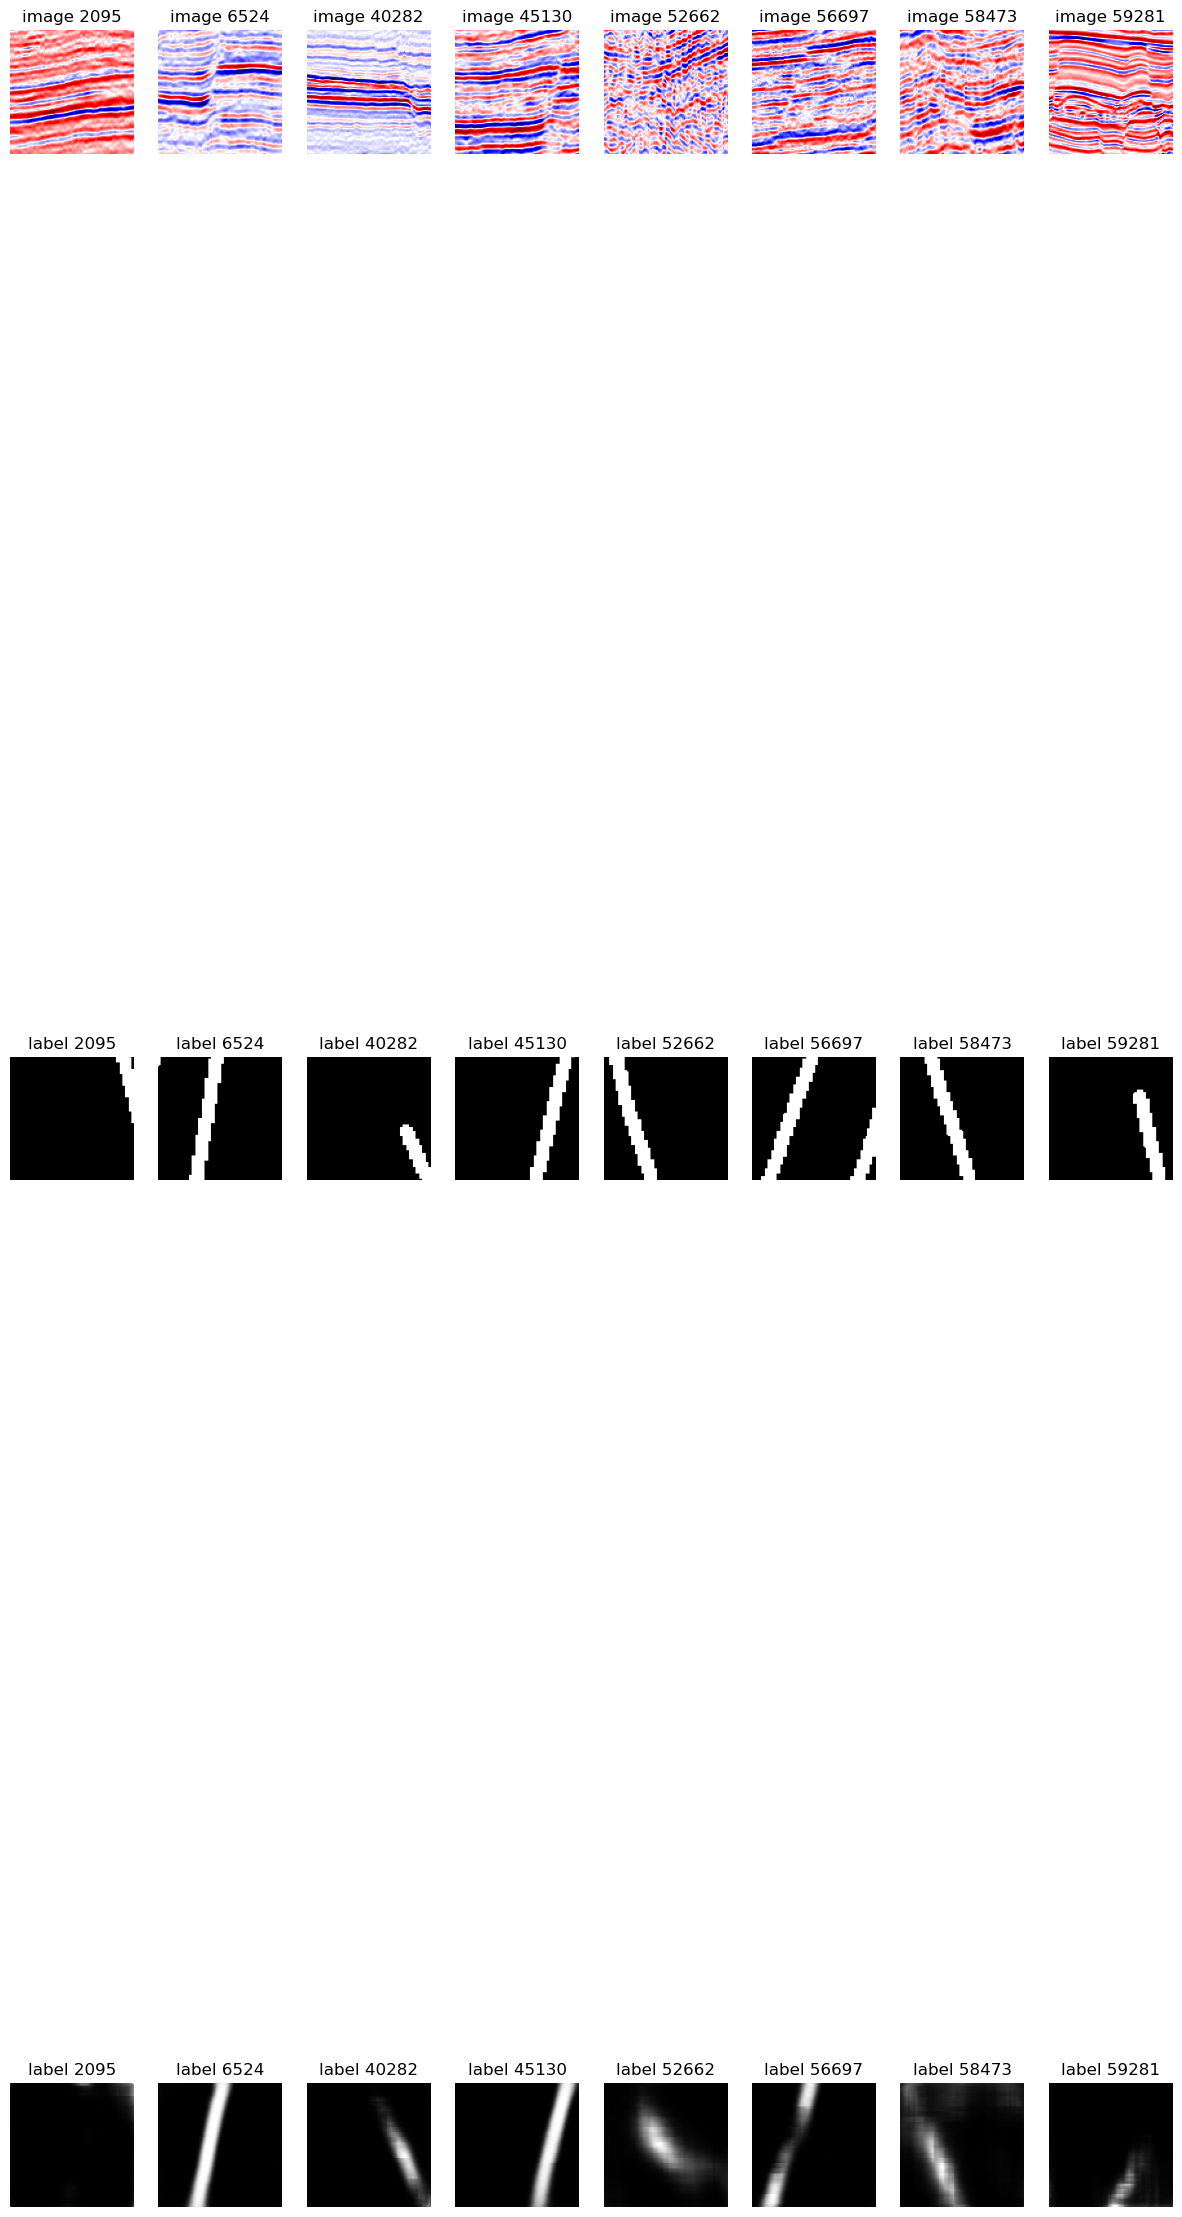

In [15]:

if INTERACTIVE_SESSION:
    thebe_data.display_sample_images(x_test, y_test, y_pred)
    

In [16]:
#model.evaluate(x=x_test)


In [17]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___46.11___minutes
                      0            1  accuracy     macro avg  weighted avg
precision  9.800000e-01         0.19      0.59  5.900000e-01  9.000000e-01
recall     5.500000e-01         0.92      0.59  7.300000e-01  5.900000e-01
f1-score   7.000000e-01         0.32      0.59  5.100000e-01  6.600000e-01
support    5.443481e+08  64617490.00      0.59  6.089656e+08  6.089656e+08
{'Avg-precision': 0.57, 'f1-score(ODS)': 0.32}
